In [1]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
assert pyro.__version__.startswith('1.8.6')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/projects/rrg-hsn/arataz/VAE/mnist/MNIST'
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = MNIST(path, train=True, transform=trans,
                      download=download)
    test_set = MNIST(path, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [2]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1, hidden_dim2,hidden_dim3):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim3)
        self.fc2 = nn.Linear(hidden_dim3, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc21 = nn.Linear(hidden_dim1, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        hidden = self.softplus(self.fc2(hidden))
        hidden = self.softplus(self.fc3(hidden))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1,hidden_dim2,hidden_dim3):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc21 = nn.Linear(hidden_dim3, z_dim)
        self.fc22 = nn.Linear(hidden_dim3, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        hidden = self.softplus(self.fc2(hidden))
        hidden = self.softplus(self.fc3(hidden))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [37]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=2, hidden_dim1=400,hidden_dim2= 100, hidden_dim3 = 20, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim1,hidden_dim2,hidden_dim3)
        self.decoder = Decoder(z_dim, hidden_dim1,hidden_dim2,hidden_dim3)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
    

In [38]:
vae = VAE()

In [39]:
optimizer = Adam({"lr": 1.0e-3})

In [40]:
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [74]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [75]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [43]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5

In [44]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 211.2936
[epoch 000] average test loss: 192.2283
[epoch 001]  average training loss: 189.2246
[epoch 002]  average training loss: 182.4076
[epoch 003]  average training loss: 168.2019
[epoch 004]  average training loss: 163.8411
[epoch 005]  average training loss: 160.2950
[epoch 005] average test loss: 159.9428
[epoch 006]  average training loss: 157.0593
[epoch 007]  average training loss: 154.7248
[epoch 008]  average training loss: 152.9139
[epoch 009]  average training loss: 151.6211
[epoch 010]  average training loss: 150.4640
[epoch 010] average test loss: 150.2917
[epoch 011]  average training loss: 149.5697
[epoch 012]  average training loss: 148.6428
[epoch 013]  average training loss: 147.7259
[epoch 014]  average training loss: 147.0982
[epoch 015]  average training loss: 146.4074
[epoch 015] average test loss: 146.4821
[epoch 016]  average training loss: 145.6135
[epoch 017]  average training loss: 145.1713
[epoch 018]  average training 

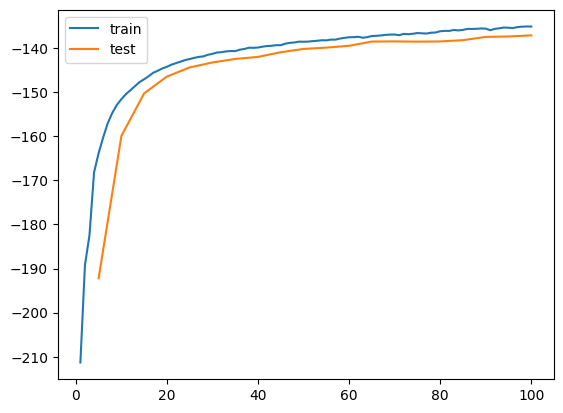

In [50]:
import matplotlib.pyplot as plt
lst = [i for i in range(1,101)]
plt.plot(lst,train_elbo, label ='train')
lst = [5*i for i in range(1,21)]
plt.plot(lst,test_elbo, label='test')
plt.legend()
plt.show()

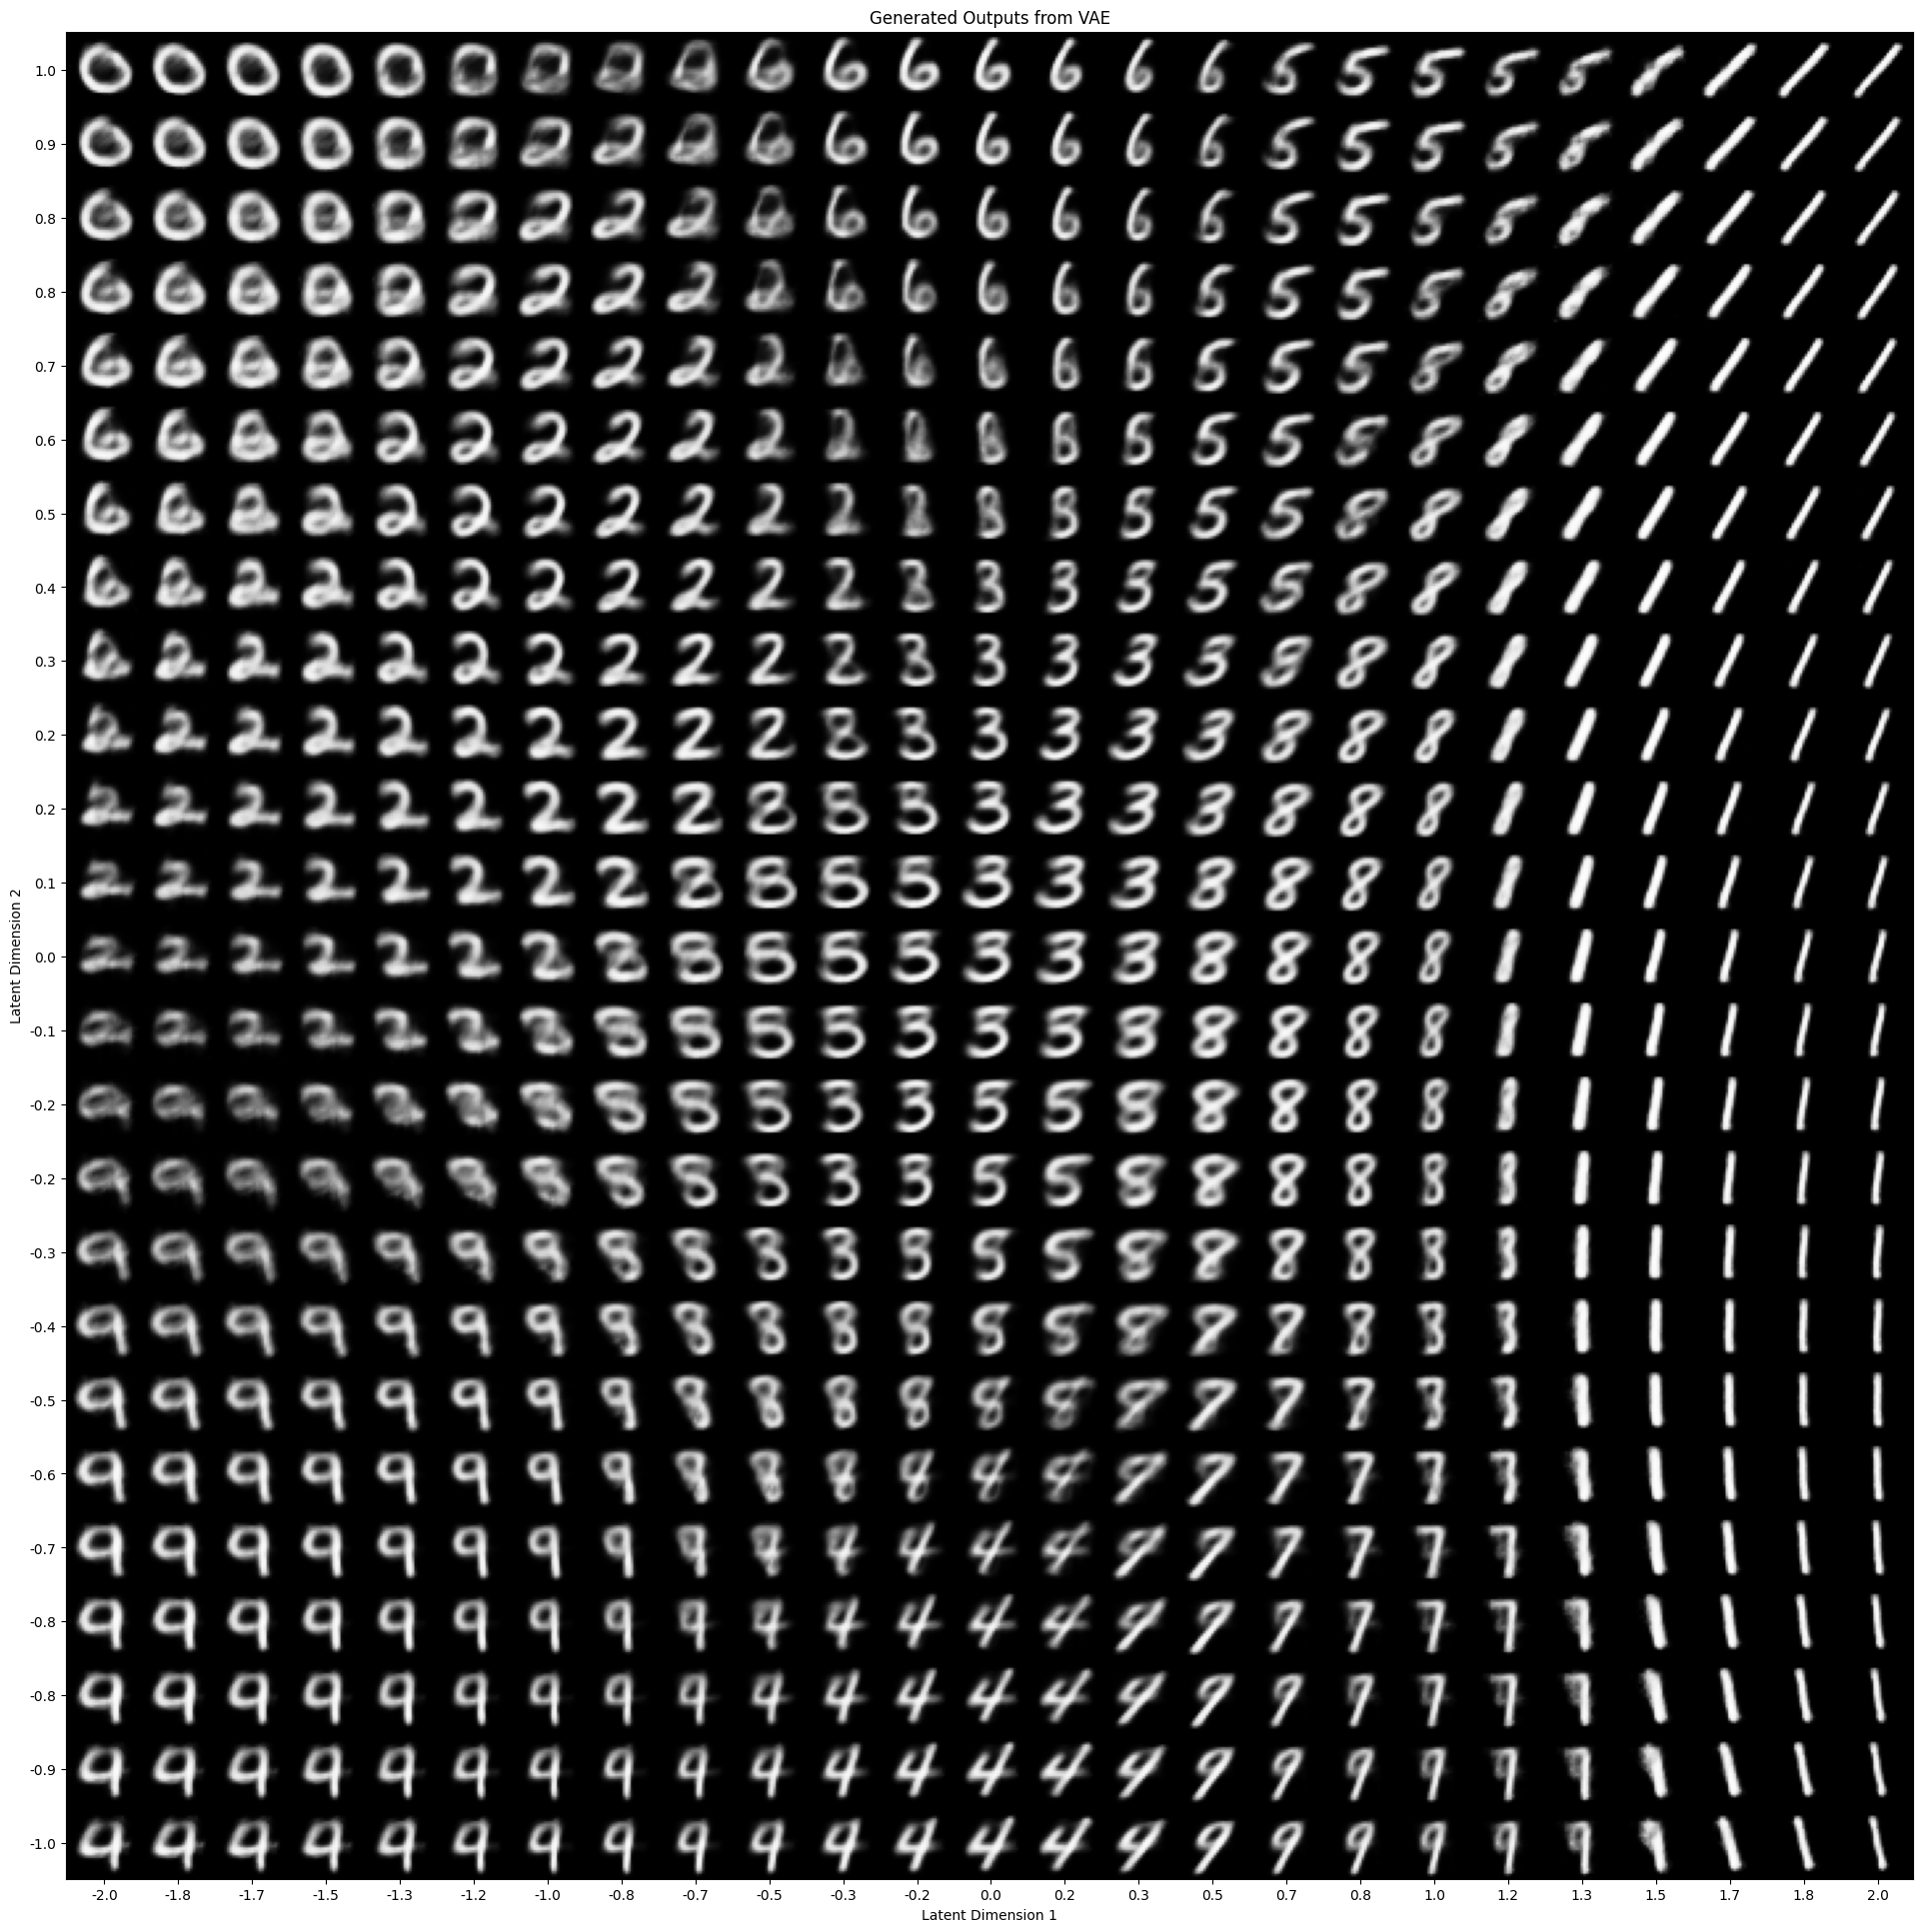

In [114]:
# Assuming you have a trained VAE instance named 'vae'
# Assuming 'device' is defined

def plot_generated_outputs(vae, scale=1, mean=2, n=25, digit_size=28, figsize=24):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-mean, mean, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('Generated Outputs from VAE')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

# Plot generated outputs
plot_generated_outputs(vae)


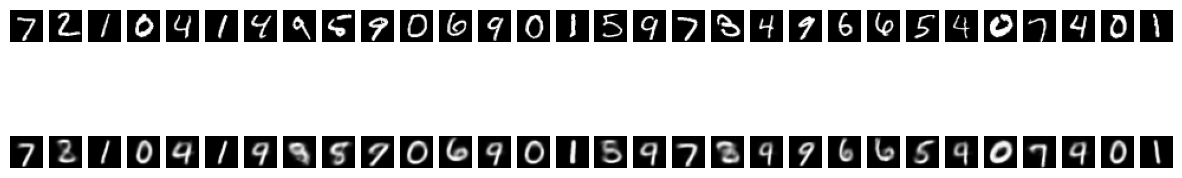

In [76]:
import torchvision.utils as vutils

# Assuming you have a trained VAE instance named 'vae'
# Assuming 'test_loader' is your DataLoader for testing images

def plot_reconstructions(vae, test_loader, num_samples=10, device="cuda"):
    dataiter = iter(test_loader)
    images, _ = next(dataiter)

    if vae.use_cuda:
        images = images.cuda()

    # Reconstruct images
    reconstructed_images = vae.reconstruct_img(images)

    # Convert images to numpy arrays
    images = images.cpu().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    # Plot original and reconstructed images
    plt.figure(figsize=(15, 3))

    for i in range(num_samples):
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i, 0], cmap='gray')
        plt.axis('off')
        reconstructed_image = reconstructed_images[i].reshape(28,28)
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(reconstructed_image, cmap='gray')
        plt.axis('off')

    plt.show()

# Plot reconstructions for at least 10 images
plot_reconstructions(vae, test_loader, num_samples=30)



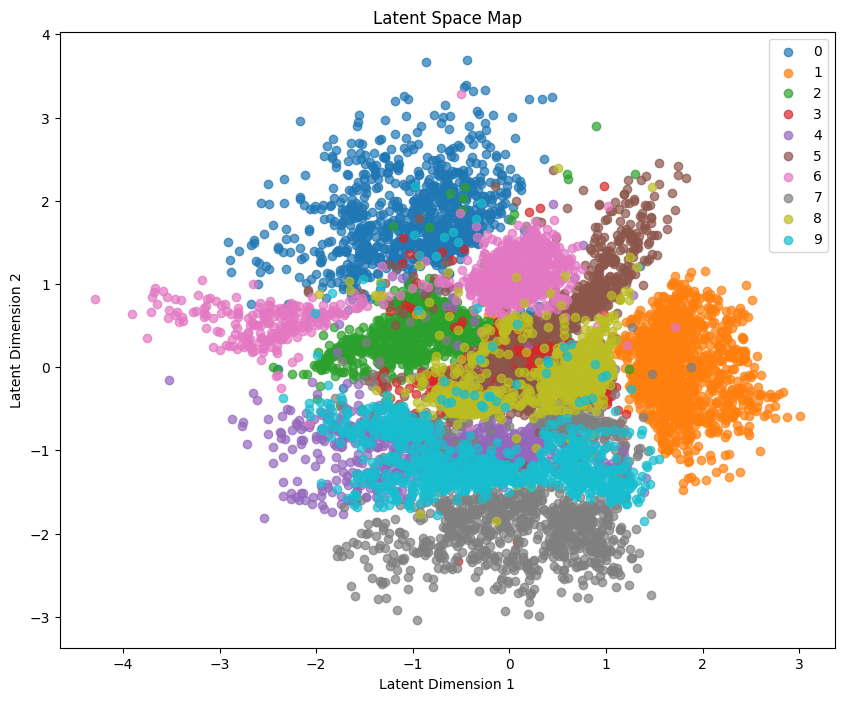

In [100]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Assuming you have a trained VAE instance named 'vae'
# Assuming 'test_loader' is your DataLoader for testing images

def get_latent_representations(vae, test_loader, device="cuda"):
    latent_vectors = []
    labels = []

    for batch in test_loader:
        images, batch_labels = batch

        if vae.use_cuda:
            images = images.cuda()

        # Encode images to get latent vectors
        z_loc, z_scale = vae.encoder(images)
        latent_vectors.append(z_loc.cpu().detach().numpy())
        labels.append(batch_labels.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    return latent_vectors, labels

def plot_latent_map(latent_vectors, labels, num_classes=10):
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        indices = labels == i
        plt.scatter(latent_vectors[indices, 0], latent_vectors[indices, 1], label=str(i), alpha=0.7)

    plt.title('Latent Space Map')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend()
    plt.show()

# Assuming you have a DataLoader named 'test_loader'
latent_vectors, labels = get_latent_representations(vae, test_loader)
plot_latent_map(latent_vectors, labels)


In [3]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from torchdiffeq import odeint_adjoint as odeint
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])
path = '~/projects/rrg-hsn/arataz/VAE/mnist/MNIST'
# download the MNIST datasets
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1, hidden_dim2,hidden_dim3):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim3)
        self.fc2 = nn.Linear(hidden_dim3, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc21 = nn.Linear(hidden_dim1, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        hidden = self.softplus(self.fc2(hidden))
        hidden = self.softplus(self.fc3(hidden))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1,hidden_dim2,hidden_dim3):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(784, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc21 = nn.Linear(hidden_dim3, z_dim)
        self.fc22 = nn.Linear(hidden_dim3, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, 784)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        hidden = self.softplus(self.fc2(hidden))
        hidden = self.softplus(self.fc3(hidden))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

In [53]:

class Classifier(nn.Module):
    
    def __init__(self, hidden_dim = 2, class_dim = 10, ode_hidden_dim=8):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, class_dim)
        self.af = nn.Softplus()
        self.softmax = nn.Softmax()
    def forward(self, z, t_span = None):
        z = self.af(self.fc1(z))
        z = self.af(self.fc2(z))
        z = self.softmax(self.fc3(z))
        return z

In [59]:
class VAE_NDE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=2, hidden_dim1=256,hidden_dim2= 128, hidden_dim3 = 64, class_dim=10, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim1,hidden_dim2,hidden_dim3)
        self.decoder = Decoder(z_dim, hidden_dim1,hidden_dim2,hidden_dim3)
        self.ode = Classifier(z_dim, class_dim)
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x, y):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc, z_scale = self.encoder(x)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder(z)
            t_span = torch.linspace(0, 1, 10)
            # class_obs = odeint(self.ode, z ,t_span)
            class_obs = self.ode(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            pyro.sample("class_obs", dist.Categorical(logits=class_obs).to_event(1), obs=y)
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x, y = None):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img



In [18]:
def train(svi, ode_optimizer, train_loader, use_cuda=False):
    t_span = torch.linspace(0, 1, 10)
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # do ELBO gradient and accumulate loss
        ode_optimizer.zero_grad()
        z_loc, z_scale = vae.encoder(x)
        class_obs = odeint(vae.ode, z_loc ,t_span)
        class_loss = F.cross_entropy(class_obs[-1], y)
        class_loss.backward()
        ode_optimizer.step()
        elbo_loss =svi.step(x)
        epoch_loss += elbo_loss + class_loss

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [60]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x , y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x, y)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [61]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, y in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x,y)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [62]:
# Run options
LEARNING_RATE = 1.0e-3
USE_CUDA = True

# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5

In [63]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE_NDE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)
ode_optimizer = torch.optim.Adam(vae.ode.parameters(), lr=LEARNING_RATE)
# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

/tmp/ipykernel_126699/235529972.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  z = self.softmax(self.fc3(z))


[epoch 000]  average training loss: 794.4449
[epoch 000] average test loss: 767.0938
[epoch 001]  average training loss: 761.3176
[epoch 002]  average training loss: 754.3045
[epoch 003]  average training loss: 749.8752
[epoch 004]  average training loss: 746.9603
[epoch 005]  average training loss: 744.4492
[epoch 005] average test loss: 743.1173
[epoch 006]  average training loss: 742.1233
[epoch 007]  average training loss: 740.2806
[epoch 008]  average training loss: 738.9915
[epoch 009]  average training loss: 737.8242
[epoch 010]  average training loss: 736.9397
[epoch 010] average test loss: 736.8159
[epoch 011]  average training loss: 736.0887
[epoch 012]  average training loss: 735.4658
[epoch 013]  average training loss: 734.7944
[epoch 014]  average training loss: 734.2201
[epoch 015]  average training loss: 733.6292
[epoch 015] average test loss: 733.8134
[epoch 016]  average training loss: 733.0219
[epoch 017]  average training loss: 732.5101
[epoch 018]  average training 

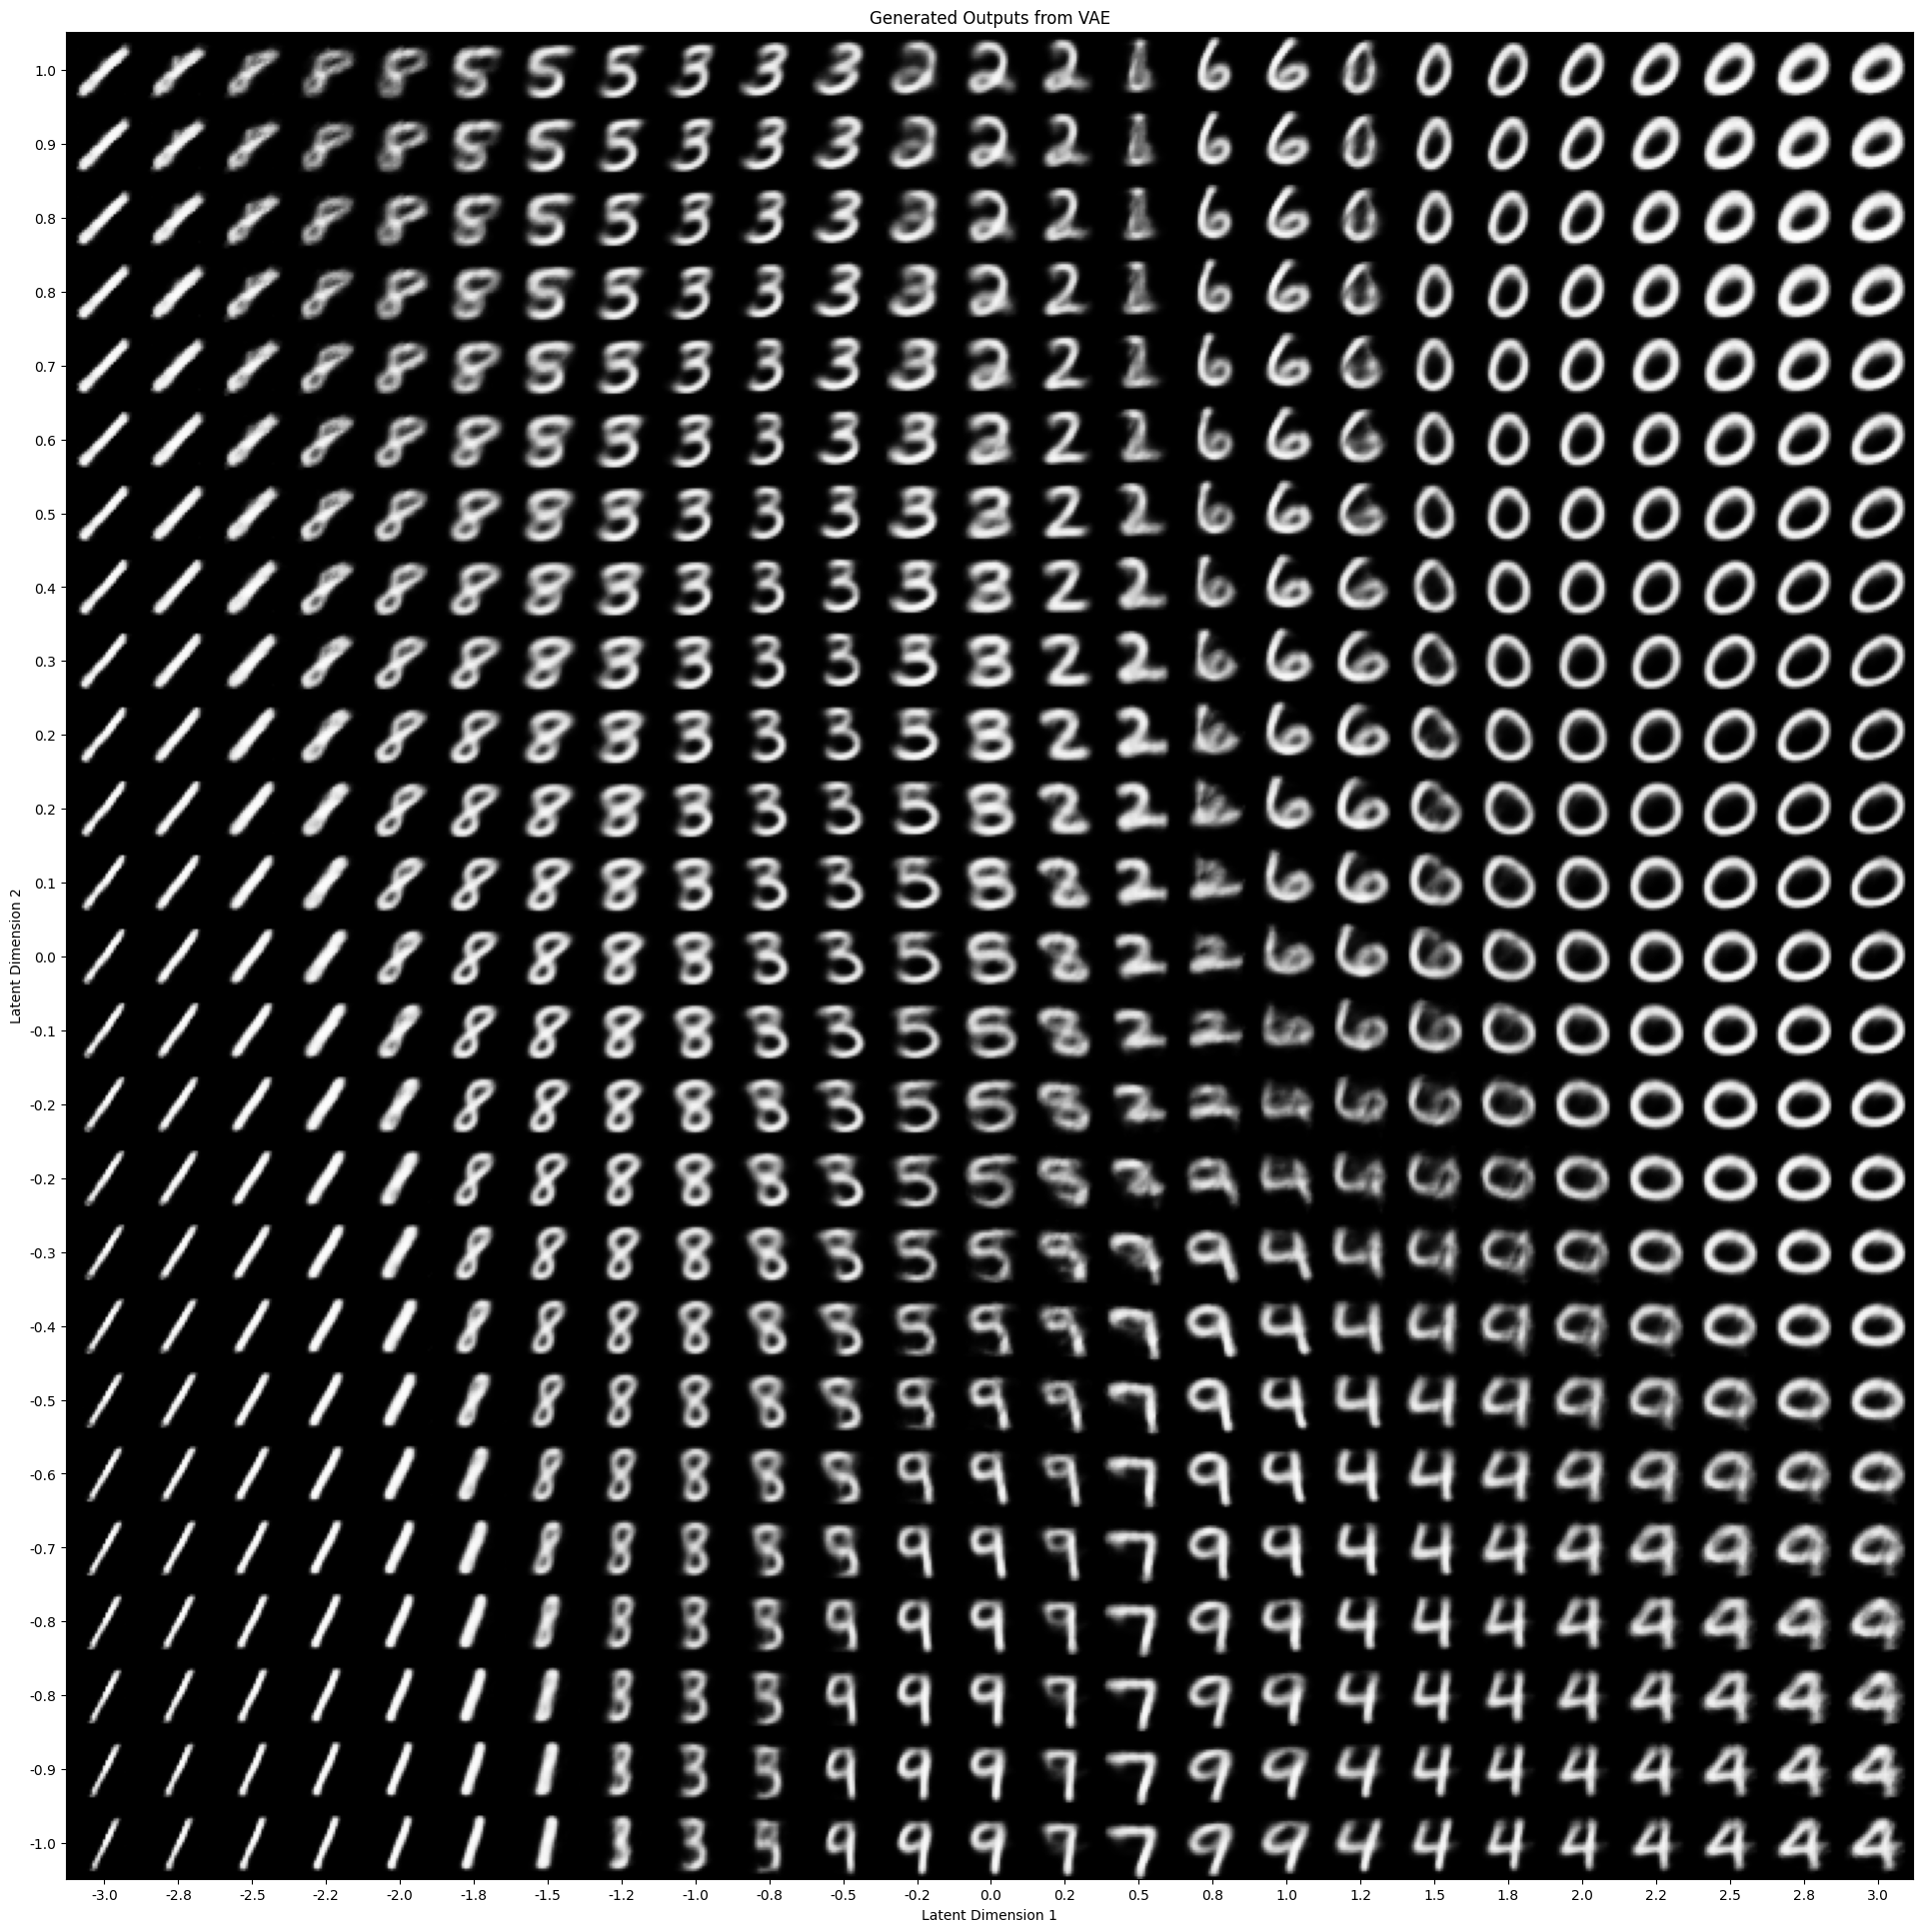

In [64]:
# Assuming you have a trained VAE instance named 'vae'
# Assuming 'device' is defined

def plot_generated_outputs(vae, scale=1, mean=3, n=25, digit_size=28, figsize=24):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-mean, mean, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = vae.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('Generated Outputs from VAE')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

# Plot generated outputs
plot_generated_outputs(vae)

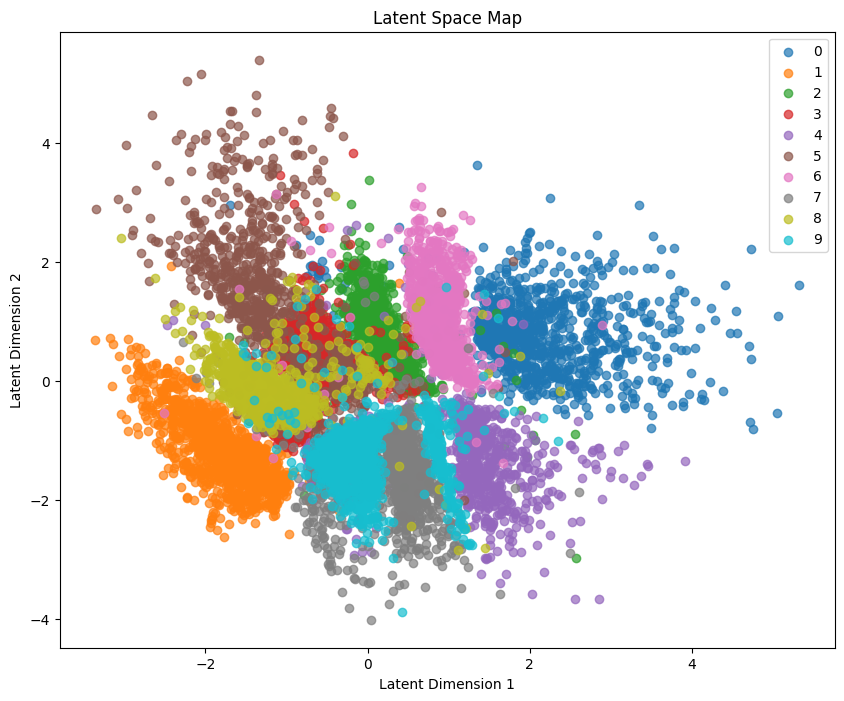

In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Assuming you have a trained VAE instance named 'vae'
# Assuming 'test_loader' is your DataLoader for testing images

def get_latent_representations(vae, test_loader, device="cuda"):
    latent_vectors = []
    labels = []

    for batch in test_loader:
        images, batch_labels = batch

        if vae.use_cuda:
            images = images.cuda()

        # Encode images to get latent vectors
        z_loc, z_scale = vae.encoder(images)
        latent_vectors.append(z_loc.cpu().detach().numpy())
        labels.append(batch_labels.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    return latent_vectors, labels

def plot_latent_map(latent_vectors, labels, num_classes=10):
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        indices = labels == i
        plt.scatter(latent_vectors[indices, 0], latent_vectors[indices, 1], label=str(i), alpha=0.7)

    plt.title('Latent Space Map')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend()
    plt.show()

# Assuming you have a DataLoader named 'test_loader'
latent_vectors, labels = get_latent_representations(vae, test_loader)
plot_latent_map(latent_vectors, labels)
